<a href="https://colab.research.google.com/github/manohar-billa/CODESOFT/blob/main/TASK_2_CREDIT_CARD_FRAUD_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
data = pd.read_csv("/content/sample_data/fraudTest.csv.zip")
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [ ]:
# extract age of customer
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.to_datetime(data['trans_date_trans_time']).dt.year - data['dob'].dt.year)

In [ ]:
# categorise ages
def age_group(age):
    if age < 18:
        return 'Teen'
    elif age < 25:
        return 'Young Adult'
    elif age < 35:
        return 'Adult'
    elif age < 50:
        return 'Middle-aged'
    elif age < 65:
        return 'Senior'
    else:
        return 'Elderly'


In [ ]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['day'] = data['trans_date_trans_time'].dt.day
data['month'] = data['trans_date_trans_time'].dt.month
data['year'] = data['trans_date_trans_time'].dt.year
data['hour'] = data['trans_date_trans_time'].dt.hour
data['minute'] = data['trans_date_trans_time'].dt.minute

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert to radians

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c  # Distance in km

# Apply to dataframe
data['distance_km'] = haversine(data['lat'], data['long'], data['merch_lat'], data['merch_long'])

In [ ]:
data['distance_km'].max()

150.9225040640718

In [ ]:
data['distance_km'].min()

0.12388306543077568

In [ ]:
def distance_category(dist):
    if dist < 0.5:
        return 'Very Near'         # < 500 meters
    elif dist < 3:
        return 'Near'              # 0.5 – 3 km
    elif dist < 15:
        return 'Moderate'          # 3 – 15 km
    elif dist < 50:
        return 'Far'               # 15 – 50 km
    else:
        return 'Very Far'          # 50 – 152+ km

data['distance_group'] = data['distance_km'].apply(distance_category)

In [ ]:
cols_to_drop = [
    'Unnamed: 0', 'first', 'last', 'street', 'city', 'state', 'zip',
    'dob', 'cc_num', 'trans_num', 'unix_time',
    'lat', 'long', 'merch_lat', 'merch_long', 'trans_date_trans_time',
]

data.drop(columns=cols_to_drop, inplace=True)

In [ ]:
data.columns

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'is_fraud',
       'age', 'day', 'month', 'year', 'hour', 'minute', 'distance_km',
       'distance_group'],
      dtype='object')

In [ ]:
sample_data = data.sample(frac=0.005, random_state=42)
len(sample_data)

2779

In [ ]:
X = sample_data.drop(columns=['is_fraud'])
y = sample_data['is_fraud']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print()
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2362, 14)
y_train shape: (2362,)

X_test shape: (417, 14)
y_test shape: (417,)


In [ ]:
cols = X_train.columns
print(cols)
print()
cat_cols = X_train.select_dtypes(include="object").columns
print(cat_cols)

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'age',
       'day', 'month', 'year', 'hour', 'minute', 'distance_km',
       'distance_group'],
      dtype='object')

Index(['merchant', 'category', 'gender', 'job', 'distance_group'], dtype='object')


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Select categorical columns
cat_cols = sample_data.select_dtypes(include="object").columns.tolist()

# Initialize encoder with unknown handling
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit on training data and transform both train and test
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2362 entries, 259975 to 296904
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   merchant        2362 non-null   float64
 1   category        2362 non-null   float64
 2   amt             2362 non-null   float64
 3   gender          2362 non-null   float64
 4   city_pop        2362 non-null   int64  
 5   job             2362 non-null   float64
 6   age             2362 non-null   int32  
 7   day             2362 non-null   int32  
 8   month           2362 non-null   int32  
 9   year            2362 non-null   int32  
 10  hour            2362 non-null   int32  
 11  minute          2362 non-null   int32  
 12  distance_km     2362 non-null   float64
 13  distance_group  2362 non-null   float64
dtypes: float64(7), int32(6), int64(1)
memory usage: 221.4 KB


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Identify numeric columns (not in categorical 'cols') as standard scaler expects 2-d matrix
num_cols = [ col for col in cols if col not in cat_cols ]
print(num_cols)

# make a copy of original data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only numeric columns
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

['amt', 'city_pop', 'age', 'day', 'month', 'year', 'hour', 'minute', 'distance_km']


In [ ]:
X_train_scaled.columns

Index(['merchant', 'category', 'amt', 'gender', 'city_pop', 'job', 'age',
       'day', 'month', 'year', 'hour', 'minute', 'distance_km',
       'distance_group'],
      dtype='object')

In [ ]:
print(type(y_test))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy        : 0.9376498800959233
Precision       : 0.037037037037037035
Recall          : 1.0
Confusion Matrix:
 [[390  26]
 [  0   1]]


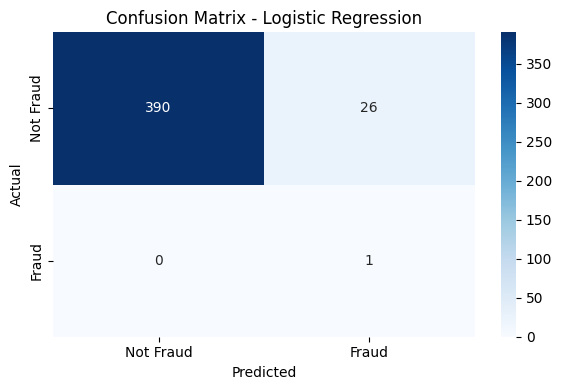

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Model
lr = LogisticRegression(solver='lbfgs', penalty="l2", class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict
y_pred = lr.predict(X_test_scaled)

# Metrics
print("Accuracy        :", accuracy_score(y_test, y_pred))
print("Precision       :", precision_score(y_test, y_pred, zero_division=0))
print("Recall          :", recall_score(y_test, y_pred))

# Confusion matrix
conf_mt = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mt)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mt, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

In [ ]:
feature_names = X_train.columns
coefficients = lr.coef_[0]

# Step 2: Create a DataFrame to sort by importance
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Step 3: View top N important features
print(coef_df.head(10))

           Feature  Coefficient  Importance
13  distance_group     4.527913    4.527913
2              amt     3.185304    3.185304
4         city_pop    -2.664926    2.664926
7              day    -1.335553    1.335553
3           gender    -1.271407    1.271407
11          minute     0.989443    0.989443
10            hour     0.366824    0.366824
12     distance_km    -0.307675    0.307675
6              age    -0.274367    0.274367
1         category    -0.240103    0.240103


Accuracy        : 0.7026378896882494
Precision       : 0.0
Recall          : 0.0
Confusion Matrix:
 [[293 123]
 [  1   0]]


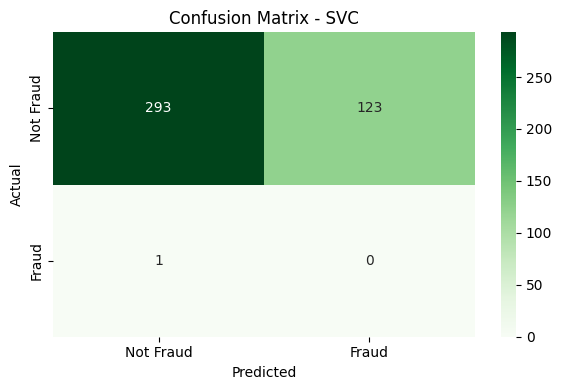

In [ ]:
from sklearn.svm import SVC

# Initialize SVC model
svc = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# Fit the model
svc.fit(X_train_scaled, y_train)

# Predict
y_pred = svc.predict(X_test_scaled)

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
print("Accuracy        :", acc)

precision = precision_score(y_test, y_pred)
print("Precision       :", precision)

recall = recall_score(y_test, y_pred)
print("Recall          :", recall)

conf_mt = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mt)

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mt, annot=True, fmt='d', cmap='Greens', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVC")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy       :", accuracy_score(y_test, y_pred))
print("Precision      :", precision_score(y_test, y_pred))
print("Recall         :", recall_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy       : 0.9976019184652278
Precision      : 0.0
Recall         : 0.0
Confusion Matrix:
[[416   0]
 [  1   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
neg_class = len(y[y==0])
print(neg_class)

pos_class = len(y[y==1])
print(pos_class)

class_weight_ratio = neg_class/pos_class

2772
7


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Initialize the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    scale_pos_weight=class_weight_ratio,  # optional for imbalance
                    random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluate
print("Accuracy       :", accuracy_score(y_test, y_pred))
print("Precision      :", precision_score(y_test, y_pred))
print("Recall         :", recall_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy       : 0.9952038369304557
Precision      : 0.0
Recall         : 0.0
Confusion Matrix:
[[415   1]
 [  1   0]]


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:11:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Create the LightGBM classifier
lgbm = lgb.LGBMClassifier(
    objective='binary',        # since it's a binary classification
    class_weight='balanced',   # handle class imbalance
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    n_jobs=-1
)

# Fit the model
lgbm.fit(X_train, y_train)

# Predict
y_pred = lgbm.predict(X_test)

# Evaluation
print("Accuracy        :", accuracy_score(y_test, y_pred))
print("Precision       :", precision_score(y_test, y_pred))
print("Recall          :", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 6, number of negative: 2356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 2362, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from catboost import CatBoostClassifier

# Optional: Set class weights manually or use 'Balanced'
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=0,                      # suppress training output
    allow_writing_files=False,      # avoid saving log files
    auto_class_weights='Balanced', # handle class imbalance automatically
    random_seed=42
)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy  : {acc}")
print(f"Precision : {prec}")
print(f"Recall    : {rec}")
print("Confusion Matrix:\n", cm)

# Optional: Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CatBoost Confusion Matrix")
plt.show()

ModuleNotFoundError: No module named 'catboost'

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


Accuracy  : 0.9976019184652278
Precision : 0.0
Recall    : 0.0
Confusion Matrix:
 [[416   0]
 [  1   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


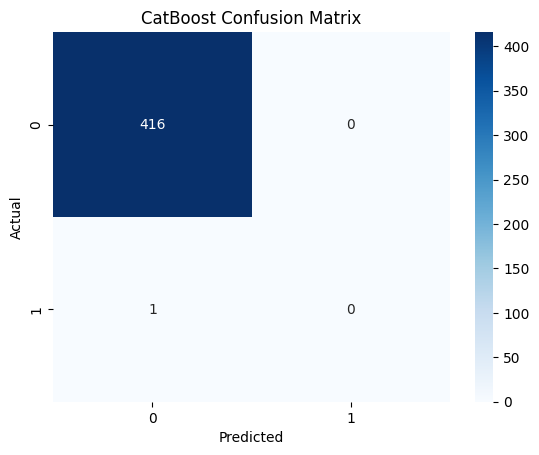

In [ ]:
from catboost import CatBoostClassifier

# Optional: Set class weights manually or use 'Balanced'
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=0,                      # suppress training output
    allow_writing_files=False,      # avoid saving log files
    auto_class_weights='Balanced', # handle class imbalance automatically
    random_seed=42
)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy  : {acc}")
print(f"Precision : {prec}")
print(f"Recall    : {rec}")
print("Confusion Matrix:\n", cm)

# Optional: Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CatBoost Confusion Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Step 1: Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1],
    'scale_pos_weight': [class_weight_ratio],  # already defined earlier based on class imbalance
}

# Step 2: Initialize base model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Step 3: GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='recall',  # prioritize recall in imbalanced cases
                           cv=3, verbose=1, n_jobs=-1)

# Step 4: Fit model
grid_search.fit(X_train, y_train)

# Step 5: Best model
best_model = grid_search.best_estimator_

# Step 6: Predict & Evaluate
y_pred = best_model.predict(X_test)

print("Best Parameters :", grid_search.best_params_)
print("Accuracy        :", accuracy_score(y_test, y_pred))
print("Precision       :", precision_score(y_test, y_pred))
print("Recall          :", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:51:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters : {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 396.0, 'subsample': 0.8}
Accuracy        : 0.9928057553956835
Precision       : 0.0
Recall          : 0.0
Confusion Matrix:
 [[414   2]
 [  1   0]]
